## Importining all the libraries and packages

In [1]:
import tensorflow as tf# here we are importing tensorflow( tensorflow is a deep learning framework,tf is low label api on top of Keras)
from tensorflow.keras.layers import * ## Here we  are importing all the subpackages inside layers(source package : Tensorflow),(parent package: Keras)(ex: Dense, Flatten, BN....etc)
from tensorflow.keras import *## here we are importing all the packages inside parent package Keras(ex: tensorflow and all..)

import numpy as np  ## Here we are importing the Numpy library for Liner alzebra computation(ex : array...)
import cv2  ## here we are importing cv2 which is otherwise called as opencv for (for computer vision , image processing , reshaping purpose )
from tqdm import tqdm ## tqdm library mostly helps us in getting the progress information in bar form.
import matplotlib.pyplot as plt # here we are importing matplotlib for Ploting or image show purpose..
AUTOTUNE = tf.data.AUTOTUNE ## AUTOTUNE will prompt the tf. data runtime to tune the value dynamically at runtime.


init = tf.keras.initializers.RandomNormal(stddev=0.02) ## Here the Initializers define the way to set the initial random weights of Keras layers.

In [3]:
import os ## Here we are importing oparating system to have the functionality of my local direactory

In [4]:
os.getcwd() ## here i am trying to getthe current direactory

'/content'

In [5]:
os.chdir(r"/content/drive/MyDrive/GANS") ## here i am changing the current direactory to the perticular direactory where my downloaded datasets is present.

In [6]:
TRAIN = r"/content/drive/MyDrive/GANS/facades/train/*" ## Defining the train direactory where all the train data are present
TEST = r"/content/drive/MyDrive/GANS/facades/test/*"  ## Defining the test direactory where all the test images are present

## Data Preprocessing

In [7]:
list_train = tf.data.Dataset.list_files(TRAIN, shuffle=True)## listing the train direactory's images with suffling all the train images dynamically as we have given Suffle = True.
list_test = tf.data.Dataset.list_files(TEST, shuffle=False) ## listing the test direactory with all images but we are not suffeling here as we have given suffle = False

print(tf.data.experimental.cardinality(list_train).numpy()) ## This operation returns the cardinality of the datasets (ex: no of images in train)
print(tf.data.experimental.cardinality(list_test).numpy()) ## This operation returns the cardinality of the datasets (ex: no of images in test)

400
106


In [8]:
def decode_img(img): ## here we are defining a function called decode image which wil take the input as img and function will return the target image(the out put of generator) and input image (the input to discriminator)
    img = tf.io.read_file(img)## This operation returns a tensor with the entire contents of the input filename which is called img here
    img = tf.io.decode_jpeg(img, channels=3) ##  encoded jpeg image is decoded into "uint8" tensor by this function(channel = 3 : for RGB for clolored images)
    ##  here tensorFlow io will convert the file formats that are  available in TensorFlow's built-in support.
    img = tf.image.resize(img, (256,512)) ## here we are resizing the images by making use of tensorflow resize operation
    
    input_img, target_img = img[:,:256], img[:,256:] ## here we are defining the numbers of imput images and target images for generator.
    ## generator will take the noise data as input image and will try to convert to the target image
    # Normalize
    input_img, target_img = normalize(input_img, target_img) ## here we are normalizing the images by making use of normalization function which is defined below.
    # Convert to float32
    input_img = tf.cast(input_img, tf.float32) ## here we are converting the arrays input images type to float values.As tensorflow takes the float value.
    target_img = tf.cast(target_img, tf.float32)## here also we are converting the arrays of target images to float datatype.
    return target_img, input_img ## Here the Function is returning the final target images and input imags


def normalize(input_img, target_img): ## here we are defining a function which will take the input images and target images for the normalizing.
## normalization means we are convering all the arrayes of values to  a perticular min and maxn range.
    input_img = input_img / 127.5 - 1
    target_img = target_img / 127.5 - 1
    return input_img, target_img ## returning the output of the function which is input image and target image

def denormalize(img):
  ## it is the  process of adding precomputed redundant data to a normalized relational database to improve read performance of the database
    img = (img + 1) * 127.5
    return img # returning the final image as a function output

In [9]:
def resize(input_image, real_image, height, width): ## Here we are defining a function which will take the input as  image,real image, width and height and it will resize the images to a perticular height and width.
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) ## here resizing all the input images to a specified size  by using nearest neighbor interpolation method.
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) ##  here resizing all the real images to a specified size  by using nearest neighbor interpolation method.

    return input_image, real_image ##here this function is returning the resized input images and real images

def random_crop(input_image, real_image): # here we are defining a function which will take the input image and real image
    stacked_image = tf.stack([input_image, real_image], axis=0)
    ## The tf.stack function is used to create a stack of tf tensors into an r+1 rank tf. tensor
    cropped_image = tf.image.random_crop(stacked_image, size=[2, 256, 256, 3]) ## here all the stacked images will be cropped accordingly.
    ## size = [2,256 ,256, 3] here we have 2 stack of colored imgages which will have the size 256,256 and "3" is for RGB(colored images)

    return cropped_image[0], cropped_image[1] ## and here it is returning the cropped input images and cropped output images
    ## in python[0] refer to 1st index which is cropped input image here and respectively for [1]> real image

@tf.function()
def random_jitter(input_img, target_img):## this function that we have defined here to generate random noise
##  it is also called gaussian jitter which is unpredictable noise.
    target_img, input_img = resize(input_img, target_img, 286, 286)# here  we are resizing the target image and input image to a perticular shap of 286,286
    target_img, input_img = random_crop(input_img, target_img), ## also we are cropping the target image and input image respectively.

    if tf.random.uniform(()) > 0.5:## conditionally the uniformity will be less than>0.5 for 50 % of the images
        target_img = tf.image.flip_left_right(target_img)## dynamically we are flipping the images here
        input_img = tf.image.flip_left_right(input_img) ## here also in run time we are flipping the images

    return input_img, target_img ## here the function is returning the final output that i input image and target image

In [10]:
train_ds = list_train.map(decode_img, num_parallel_calls=AUTOTUNE) ## here we decoding the images by map function.
## num_parallel_calls = AUTOTUNE > it will prompt the tensor data runtime to tune the value dynamically at runtime.
train_ds = train_ds.map(random_jitter, num_parallel_calls=AUTOTUNE) ## here we are creating the normally distributed random noise in train data
train_ds = train_ds.repeat() #here  number of repetitions for each element is happening
train_ds = train_ds.batch(1)# it creates the batches of tensors and the batching will be deterministic thetwhy we have specified 1 over  here.
train_ds = train_ds.prefetch(AUTOTUNE)
## Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training steps the input pipeline is reading the data for step s+1 and doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.
train_ds ## returning the train data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [11]:
test_ds = list_test.map(decode_img, num_parallel_calls=AUTOTUNE) ## here we decoding the images by map function.
test_ds = test_ds.batch(1)## 
test_ds = test_ds.prefetch(AUTOTUNE)
## Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training the input  is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.
test_ds ## returning the test images

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

## Ploting the noise Data

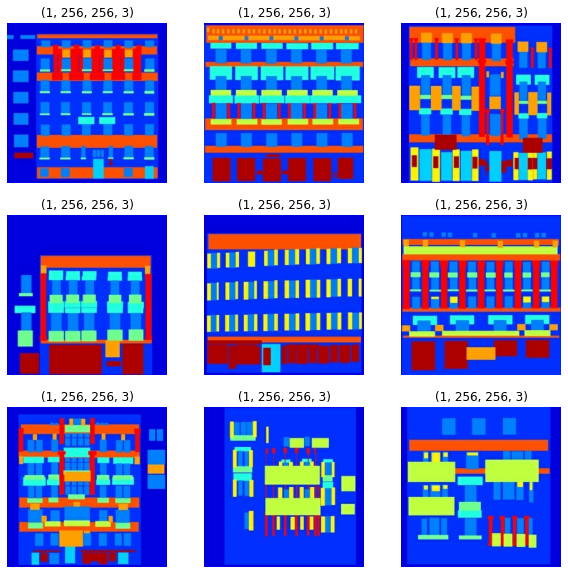

In [12]:
plt.figure(figsize=(10, 10)) ## here simply we are plotting the test images which are generated randomly which is other wise called noise for generator.
counter = 0 ## starting from 1st image tensor just as a varial of index 0.
for sat, map_ in test_ds:
    plt.subplot(3, 3, counter + 1)# one by ne image will be plotted
    plt.imshow(np.squeeze(sat) * 0.5 + 0.5) 
    plt.title(sat.shape) ## the title will be the shape information of the image
    plt.axis("off")## here we dont want to see x axis and y axis .....thatswhy axis("off")
    counter+=1
    if counter==9: break ## when 9 images will be plotted the for loop will be breaked

## Ploting the real Data

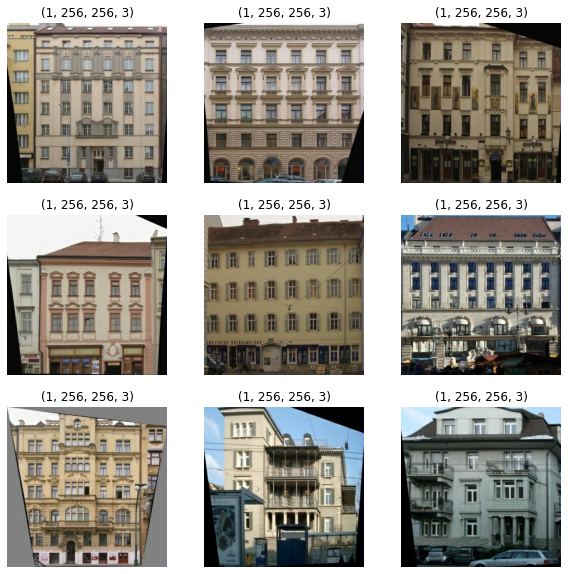

In [13]:
plt.figure(figsize=(10, 10))## here simply we are plotting the test images which are generated randomly which is other wise called noise for generator.
counter = 0 ## starting from 1st image tensor just as a varial of index 0.
for sat, map_ in test_ds:
    plt.subplot(3, 3, counter + 1)## starting from 1st image tensor just as a varial of index 0.
    plt.imshow(np.squeeze(map_)* 0.5 + 0.5)
    plt.title(sat.shape)## the title will be the shape information of the image
    plt.axis("off")## here we dont want to see x axis and y axis .....thatswhy axis("off")
    counter+=1
    if counter==9: break ## when 9 images will be plotted the for loop will be breaked

## Creating The Custome Discriminator

In [14]:
def Discriminator(image_shape):##  here we are defining a discriminator which will take the image shape as input.
    image = Input(shape=image_shape)    # here we are mentioning the input image for which discriminator will take
    target = Input(shape=image_shape)   # and here the  target output of the discriminator is defined...
    
    concat = Concatenate()([image, target])## we are concatenating the  images channel wise
    
    x = Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(concat)
    ## here we have  defined a convolutional layer which have kernel size of (4,4) and stride = (2,2) and there will be no padding
    ## convd > convolution we make use for not loosing the neighborhood informtion instead of ANN
    ## stride > the number of jumping step it will exclude from left to right while in convoluting
    ## padding> padding refers to the amount of pixels added to an image when it is being processed by the kernel.
    x = LeakyReLU(alpha=0.2)(x) ## here we are adding the leakyrelu activation function for featuremap.
    
    x = Conv2D(128, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
    ## here we have  defined a convolutional layer which have kernel size of (4,4) and stride = (2,2) and there will be no padding and also we have initializing the weights.
    x = BatchNormalization()(x) ## here we are adding the batchnormalization which will accumulate the weight distribution after the forward propagetion to avoid the vanishing gradiant issues.
    x = LeakyReLU(alpha=0.2)(x) ## here er are using LeakyRelu activation function.
    
    x = Conv2D(256, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
    ## here we have  defined a convolutional layer which have kernel size of (4,4) and stride = (2,2) and there will be no padding and also we have initializing the weights.
    x = BatchNormalization()(x) ## here we are adding the batchnormalization which will accumulate the weight distribution after the forward propagetion to avoid the vanishing gradiant issues.
    x = LeakyReLU(alpha=0.2)(x) ## ## here er are using LeakyRelu activation function.
    
    x = Conv2D(512, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
    ## here we have  defined a convolutional layer which have kernel size of (4,4) and stride = (2,2) and there will be no padding and also we have initializing the weights though kernel initializer
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(1, kernel_size=(4,4), padding='same', kernel_initializer=init)(x)
    ## here we have  defined a convolutional layer which have kernel size of (4,4) and stride = (2,2) and there will be no padding and also we have initializing the weights through the kernel initializer
    x = Activation('sigmoid')(x) ## although we have to classify 2 classes thatswhy we have mentioned here sigmaid activation function which will give a value ranges(0,1)
    
    model = Model([image, target], x) ## here we are fitting discriminator model with image and target image.
    return model ## here the function is returning the model

In [15]:
Discriminator = Discriminator((256,256,3)) ## specifying the size that discriminator has taken
Discriminator.summary() ## here we can have look on custom layers which we have created.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 6)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [16]:
def encoder(inputs, filters, batch_norm=True):## here we are defining the a function block called encoder which will be used in generator..it is otherwise used as upsampling
    x = Conv2D(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputs)
    ## ## here we have  defined a convolutional layer which have kernel size of (4,4) and stride = (2,2) and there will be no padding and also we have initializing the weights through the kernel initializer
    if batch_norm:
        x = BatchNormalization()(x, training=True)## here we are making the parameter again trainable and we are using the batchnormalization
    x = LeakyReLU(alpha=0.2)(x)## here we are suing the LeakyRelu activation function
    return x

def decoder(inputs, skip, filters, dropout=True):## here we are using a decoder block which will be used in the generater it is otherwise called as downsampling
    x = Conv2DTranspose(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputs)
    ## ## here we have  defined a convolutional layer which have kernel size of (4,4) and stride = (2,2) and there will be no padding and also we have initializing the weights through the kernel initializer
    x = BatchNormalization()(x, training=True) ## here we are using the batch normalization
    if dropout:
        x = Dropout(0.5)(x, training=True) ## over here we are also adding the roupout layers for skip connection
    x = Concatenate()([x, skip])
    x = Activation('relu')(x)
    return x ## returning the custome configuration

## Defining the custome generator

In [17]:
def Generator(input_shape): ## here we are definig the genetor
    inputs = Input(shape=input_shape) ## which will take the input as defined input shape
    
    x1 = encoder(inputs, 64, batch_norm=False) ## here we are using the encoder block without batch normalization
    x2 = encoder(x1, 128) ## here we are using encoder with 128 neurons
    x3 = encoder(x2, 256) ## here we are using encoder with 256 neurons
    x4 = encoder(x3, 512)## here we are using encoder with 512 neurons
    x5 = encoder(x4, 512) ## here we are using encoder with 512neurons
    x6 = encoder(x5, 512) ## here we are using encoder with 512 neurons
    x7 = encoder(x6, 512) ## here we are using encoder with 512 neurons
    
    x = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x7)
    ## here we have  defined a convolutional layer which have kernel size of (4,4) and stride = (2,2) and there will be no padding and also we have initializing the weights through the kernel initializer
    x = ReLU()(x) ## here we are using the relu activation function
    
    y1 = decoder(x, x7, 512)## here we are using the decoder block with 512 neurons
    y2 = decoder(y1, x6, 512)## here we are using the decoder block with 512 neurons
    y3 = decoder(y2, x5, 512)## here we are using the decoder block with 512 neurons
    y4 = decoder(y3, x4, 512, dropout=False)## here we are using the decoder block with 512 neurons
    y5 = decoder(y4, x3, 256, dropout=False)## here we are using the decoder block with 512 neurons
    y6 = decoder(y5, x2, 128, dropout=False)## here we are using the decoder block with 512 neurons
    y7 = decoder(y6, x1, 64, dropout=False)## here we are using the decoder block with 512 neurons
    
    x_new = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(y7)
    ## conv2dtranspose is used to upsampled the images to the the required training size data shape
    x_new = tf.keras.activations.tanh(x_new) ## here we are using tanh activation function
    
    model = Model(inputs, x_new)## fitting the model
    return model ## returining the final model

In [18]:
Generator = Generator((256,256,3))
Generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 128, 128, 64  3136        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 128, 128, 64  0           ['conv2d_5[0][0]']               
                                )                                                           

In [19]:
generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5) ## once the loss for the generator wil be calculated we need a optimizer to update the weights of the generator.
## optimizer tries to minimize the loss in trauining and over here we are using Adam optimizer
discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5) ## respectively we have defined the optimizer for discriminator which will minimize the loss.

In [20]:
loss_fn = tf.keras.losses.BinaryCrossentropy()## here we have used the loss function as Binary cross entropy
## we can make use of binarycross entropy while we will have <=2 class. it is especially used when our output or target variable is having 2 output(2 category).
## when we have more that 2 classes then we can go for categorical crossentropy.
mae = tf.keras.losses.MeanAbsoluteError()## mean absolute error is another kind of loss function we use when our target variable is contous.

In [21]:
#Generator Losses
def Generator_loss(disc_generated_output, gen_output, target):## here we are defining the function which will calculate the loss of generator
    gan_loss = loss_fn(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = mae(target, gen_output)
    gen_loss = gan_loss + (100 * l1_loss)
    return gen_loss

In [22]:
#Discrimantor Losses
def Discriminator_loss(disc_real_output, disc_generated_output): ## here we are defining a function which will calculate the discriminator loss
    real_loss = loss_fn(tf.ones_like(disc_real_output), disc_real_output)## tf.ones if the out put is True it will give 1 
    generated_loss = loss_fn(tf.zeros_like(disc_generated_output), disc_generated_output)## if the output will not be matching(False) it will give zero
    total_disc_loss = real_loss + generated_loss## adding the real loss and generator loss
    return total_disc_loss ## returining the total loss

In [23]:
@tf.function()
def train_step(input_img, target_img):## here we are defining the a function called train step
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #Generating images using input_images(fake) or noise
        generated = Generator(input_img, training=True)## here we have generated some of the fake images for training the generator
        
        disc_real = Discriminator([input_img, target_img], training=True)## classifying the images by Discriminator
        disc_generated = Discriminator([input_img, generated], training=True)
        
        #Generator Loss
        gen_total_loss = Generator_loss(disc_generated, generated, target_img)## here we have total loss
        
        #Discriminator Loss
        Disc_loss = Discriminator_loss(disc_real, disc_generated)
        
    generator_gradients = gen_tape.gradient(gen_total_loss, Generator.trainable_variables)## we want to udate the weight of generator
    generator_optimizer.apply_gradients(zip(generator_gradients, Generator.trainable_variables)) ## applied the weight update or backpropagation over here
    
    discriminator_gradients = disc_tape.gradient(Disc_loss, Discriminator.trainable_variables)## here we have to update the weight of discriminator
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, Discriminator.trainable_variables))## and over here we are applying the weight updation
    
    return gen_total_loss, Disc_loss ## here it is returning the generator total loss and discriminator total loss

## Training

In [24]:
generator_loss = [] ## creating a empty list where we will store the generator loss
discriminator_loss = [] ## creating a empty list where we will store the discriminator loss

for epoch in range(100):## here we are training for 100 epochs
    for sat_img, map_img in train_ds.take(2000): 
        gen_loss, disc_loss = train_step(sat_img, map_img)## here the genarator loss and discriminator loss is being accumulated
        generator_loss.append(gen_loss), discriminator_loss.append(disc_loss)## over here we are just appening separately to the empty list respective
        
    if epoch%10 == 0: ## once after 10  epochs generator loss,discrimintor loss and number of epochs will bw prined
        print(f"Epochs:{epoch} || Generator_Loss: {gen_loss:.3f} || Discriminator_Loss: {disc_loss:.3f}")

Epochs:0 || Generator_Loss: 29.875 || Discriminator_Loss: 0.636
Epochs:10 || Generator_Loss: 32.237 || Discriminator_Loss: 0.605
Epochs:20 || Generator_Loss: 23.447 || Discriminator_Loss: 0.476
Epochs:30 || Generator_Loss: 24.592 || Discriminator_Loss: 0.164
Epochs:40 || Generator_Loss: 22.386 || Discriminator_Loss: 0.250
Epochs:50 || Generator_Loss: 19.875 || Discriminator_Loss: 0.340
Epochs:60 || Generator_Loss: 23.565 || Discriminator_Loss: 0.629
Epochs:70 || Generator_Loss: 24.436 || Discriminator_Loss: 0.090
Epochs:80 || Generator_Loss: 29.442 || Discriminator_Loss: 0.201
Epochs:90 || Generator_Loss: 18.427 || Discriminator_Loss: 0.736


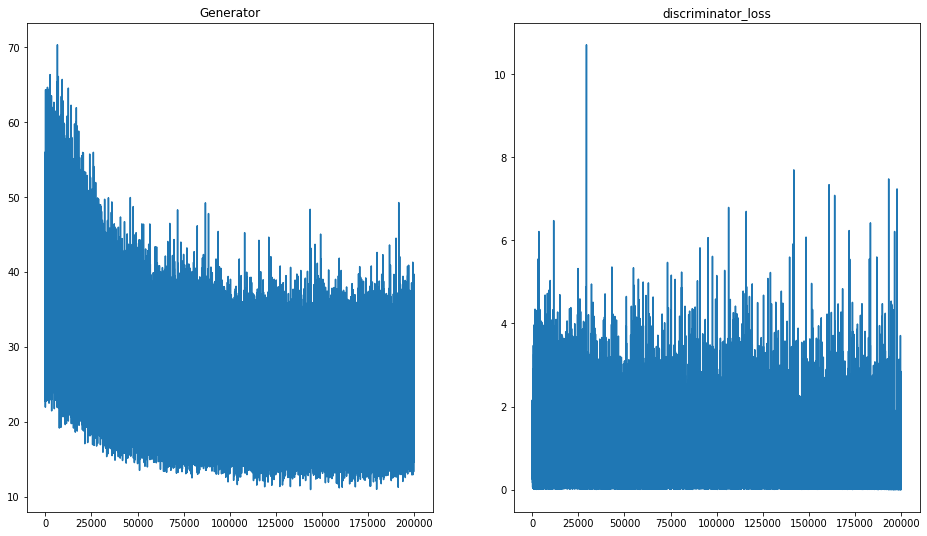

In [28]:
plt.figure(figsize=(16,9))
plt.subplot(121), plt.plot(generator_loss), plt.title('Generator')## plotting the generator loss to visualize in graph
plt.subplot(122), plt.plot(discriminator_loss), plt.title("discriminator_loss") ## plotting the discriminator loss to visualize in graph
plt.show()

## Saving the model

In [32]:
Generator.save("gen.h5")## here we are saving the generator model in our local direactory
Discriminator.save("discrmntr.h5")## here we are saving the discriminator model in our local machine

## Predicting and plotting the test data by the generator model and comparing

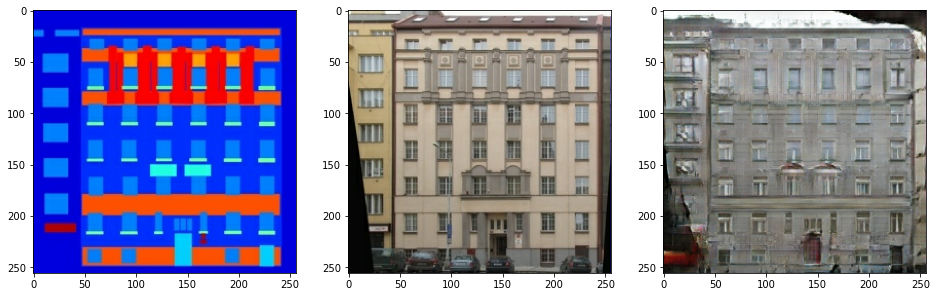

In [31]:
x, y = decode_img("/content/drive/MyDrive/GANS/facades/test/1.jpg")## loading one test image for prediction
preds = Generator.predict(tf.expand_dims(x, axis=0))## here we are predicting the image with the generator model

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))## here we are denormalizing the image
plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(133), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))## squeezing the image over here
plt.show()

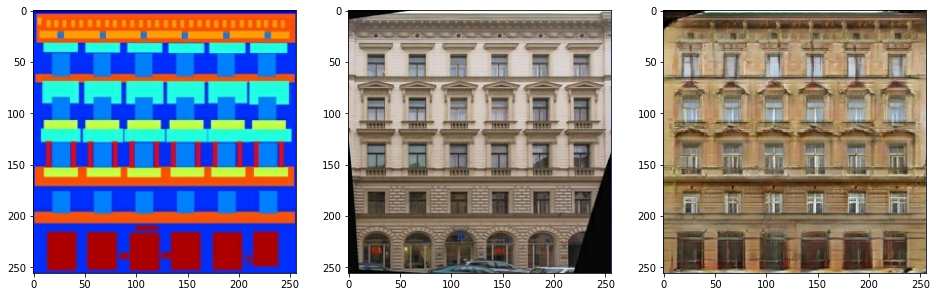

In [33]:
x, y = decode_img("/content/drive/MyDrive/GANS/facades/test/10.jpg")# loading one test image for prediction
preds = Generator.predict(tf.expand_dims(x, axis=0))## here we are predicting the image with the generator model

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))## here we are denormalizing the image
plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(133), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))## squeezing the image over here
plt.show()

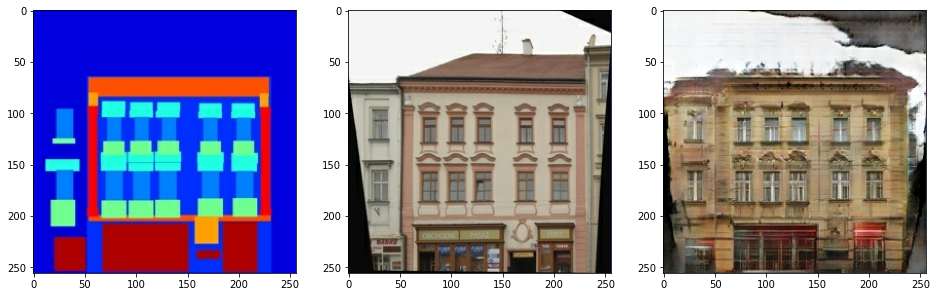

In [34]:
x, y = decode_img("/content/drive/MyDrive/GANS/facades/test/101.jpg")
preds = Generator.predict(tf.expand_dims(x, axis=0))## here we are predicting the image with the generator model

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))## here we are denormalizing the image
plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(133), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))## squeezing the image over here
plt.show()

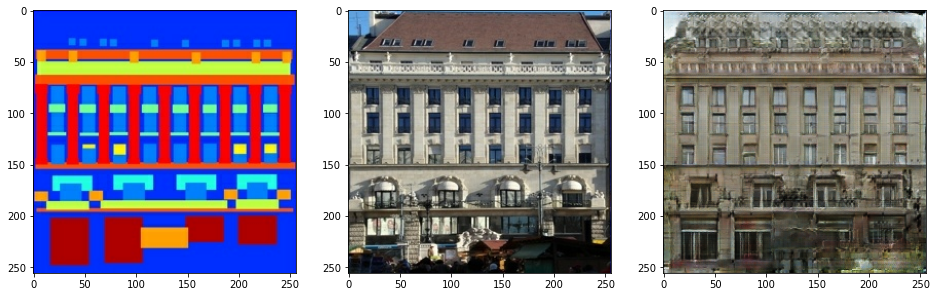

In [35]:
x, y = decode_img("/content/drive/MyDrive/GANS/facades/test/103.jpg")#loading one test image for prediction
preds = Generator.predict(tf.expand_dims(x, axis=0))## here we are predicting the image with the generator model

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))## here we are denormalizing the image
plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(133), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))## squeezing the image over here
plt.show()

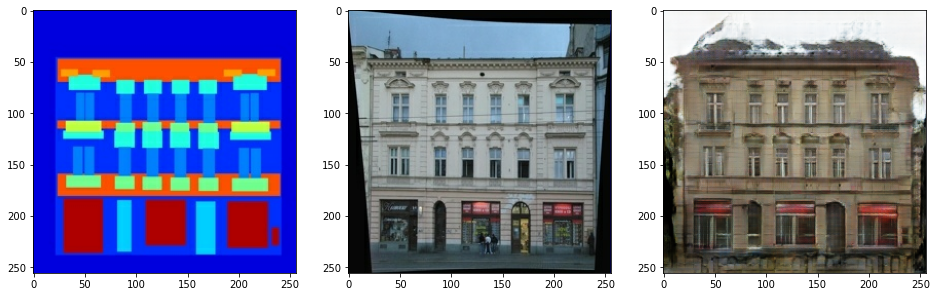

In [36]:
x, y = decode_img("/content/drive/MyDrive/GANS/facades/test/12.jpg")## loading one test image for prediction
preds = Generator.predict(tf.expand_dims(x, axis=0))## here we are predicting the image with the generator model

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))## here we are denormalizing the image
plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(133), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))## squeezing the image over here
plt.show()

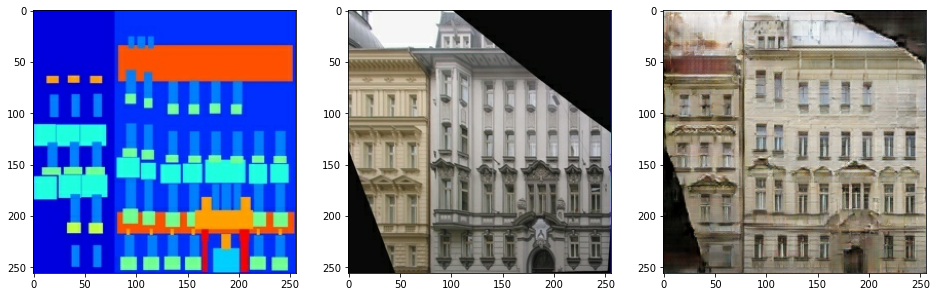

In [37]:
x, y = decode_img("/content/drive/MyDrive/GANS/facades/test/20.jpg")## loading one test image for prediction
preds = Generator.predict(tf.expand_dims(x, axis=0))## here we are predicting the image with the generator model

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))## here we are denormalizing the image
plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(133), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))## squeezing the image over here
plt.show()